# Neural Network Optimization and Tuning

In this tutorial you will learn how to implement a number of optimization techniques in PyTorch along with other tuning methods, to effectively apply the gradients to update the network parameters. 

We will introduce the concepts of different methods, their motivation, as well as the the implementation details in Pytorch.

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, datasets, models
import numpy as np
import matplotlib.pyplot as plt
from torch.autograd import Variable
from collections import namedtuple
from IPython.display import Image
%matplotlib inline
np.random.seed(2019)

We use the PyTorch dataset API to load a dataset with exactly the same properties as the MNIST handwritten digits dataset. However, instead of handwritten digits, this dataset contains images of 10 different **common clothing items**, hence the name **Fashion-MNIST** . Performance on MNIST saturates quickly with simple network architectures and optimization methods. This dataset is more difficult than MNIST and is useful to demonstrate the relative improvements of different optimization methods. 

Some of the characteristics are mentioned below.

- 28x28 images
- 10 classes
- Single color channel (B&W)
- Centered objects
- 50000 training set members
- 10000 test set members


In [2]:
# Fashion Class that enables the Dataset download and basic transformations
class Fashion(datasets.MNIST):
    def __init__(self, root, train=True, transform=None, target_transform=None, download=False):
        self.urls = [
            'http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/train-images-idx3-ubyte.gz',
            'http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/train-labels-idx1-ubyte.gz',
            'http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/t10k-images-idx3-ubyte.gz',
            'http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/t10k-labels-idx1-ubyte.gz',
        ]
        super(Fashion, self).__init__(
            root, train=train, transform=transform, target_transform=target_transform, download=download
        ) 

def decode_label(l):
    return ["Top",
     "Trouser",
     "Pullover",
     "Dress",
     "Coat",
     "Sandal",
     "Shirt",
     "Sneaker",
     "Bag",
     "Ankle boot"
    ][l]

In [3]:
train_data = Fashion('/tmp/data', train=True, download=True, transform=transforms.Compose([
                                    transforms.ToTensor(),
                                    transforms.Normalize((0.1307,), (0.3081,))
                            ]))

test_data = Fashion('/tmp/data', train=False, download=True, transform=transforms.Compose([
                                   transforms.ToTensor(),
                                   transforms.Normalize((0.1307,), (0.3081,))
                            ]))

## Random examples from the Fashion-MNIST dataset

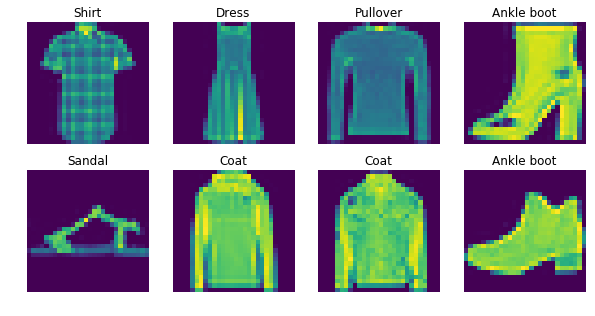

In [4]:
idxs = np.random.randint(100, size=8)
f, a = plt.subplots(2, 4, figsize=(10, 5))
for i in range(8):
    X = train_data.train_data[idxs[i]]
    Y = train_data.train_labels[idxs[i]]
    r, c = i // 4, i % 4
    a[r][c].set_title(decode_label(Y))
    a[r][c].axis('off')
    a[r][c].imshow(X.numpy())
plt.draw()

## Build a model

As we are more focussed on evaluating how the different optimization methods perform, we'll be constructing a very simple feedforward network.

In [5]:
class FashionModel(nn.Module):
    def __init__(self):
        super(FashionModel, self).__init__()
        self.fc1 = nn.Linear(784, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 10)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.log_softmax(self.fc3(x))
        return x
print(FashionModel())

FashionModel(
  (fc1): Linear(in_features=784, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=10, bias=True)
)


## A Simple Optimizer in PyTorch

The most simple optimization method is to update the network parameters by adding the negative of the gradient scaled by a fixed learning rate $\eta$.

$$ \textbf{W'} \leftarrow \textbf{W} - \eta \nabla L(\textbf{W}) $$

PyTorch provides us a very simple and expressive API for creating custom optimizers. An optimizer in PyTorch subclasses `torch.optim.Optimizer` and is required to specify two methods.

`__init__`: Must call the superclass `__init__` and provide a list of network parameters, `params`, to optimize and a dictionary of default values provided to each parameter group, `defaults`. 

`step`: Performs an update on the network parameters. 

The meat of your optimizer logic lies in the `step` method. In this method you should update your model parameters with the help of some useful internal data structures. Let's define these to make the following code more clear.

`self.param_groups`: When you initialize an optimizer object, you are required to provide the list of parameter objects to be optimized. In the case of `FashionModel`, there are 6 parameters -- each `Linear` layer has a weight matrix parameter and a bias vector. All of these 6 parameters are considered within a single `param_group`. This `group` will be a dictionary with an entry `params` that contains an iterable of all 6 parameters, as well as entries for all `defaults`. These `defaults` are generally useful for storing small values like hyperparameters that are standard across all parameter groups. There are more advanced cases where it can come in handy to have different values for certain entities depending on the `param_group`. 

`self.state`: This maintains state for a given parameter. Essentially it maps a parameter to a dictionary of data that you want to keep track of. This is useful in cases where you want to keep state on a per-parameter basis.

**IMPORTANT**: Unlike most other use cases in PyTorch, operations on parameters and state data should be done **inplace**. This ensures that the updated parameters are not updated copies of the original. In the following sample implementations, you may see some unfamiliar operations. Functions like `torch.add_` and `torch.mul_` are just inplace analogues of standard PyTorch functions. See http://pytorch.org/docs/master/torch.html for further details.

## Choosing the right divergence, or loss function

This is particularly important for classification, since typically a differentiable function is choosen to approximate the step loss prescribed by accuracy. The best of divergence is steep far from the optimum, but shallow at the optimum. One counter-example of this is if we choose to use L2 loss on top of the KL divergence for a classfication problem - this loss function 

## Let's write our *Trainer* - Perform mini-batch gradient Decent

- **What is it?** Performs update for every mini-batch of data, i.e. calculate gradient only using a small batch.
    
- **Why?** On the one hand, Batch gradients that uses the whole dataset for one update is slow and intractable for large datasets to fit into memory; on the other hand, stochastic gradient descent that updates for each data has high variance in updates. So mini-batch is a good compromise. Indeed, for convex functions, convergence rate for one-sample SGD is $O(\frac{1}{\sqrt{k}})$, while for mini-batch updates with batches of size $b$ and number of steps $k$, the convergence rate is $O(\frac{1}{\sqrt{bk}}+\frac{1}{k})$ - although we perform $b$ times as many computations per iteration as one-sample SGD and hence get a degradation oAlso, matrix multiplication is faster. Why can we not simply loop through the data by batch, i.e. why we need randomness? The reason is if we loop through the data deterministically, we may get cyclic behavior. In other words, it is best that each batch we can an equally representative and diffuse data points so that we have good estimate of the gradients and loss.
    
- **What else to keep in mind?** The common mini-batch size are 32-256. When it is too small, it is too slow and high variance; when it is too big, it exceeds the memory capacity, is harder to escape from local minima and tends to decay in generalization.

In [6]:
train_size = train_data.train_data.shape[0]
val_size, train_size = int(0.20 * train_size), int(0.80 * train_size) # 80 / 20 train-val split
test_size = test_data.test_data.shape[0]
batch_size = 100

# Add dataset to dataloader that handles batching
train_loader = torch.utils.data.DataLoader(train_data, 
                                           batch_size=batch_size,
                                           sampler=torch.utils.data.sampler.SubsetRandomSampler(np.arange(val_size, val_size+train_size)))
val_loader = torch.utils.data.DataLoader(train_data, 
                                           batch_size=batch_size, 
                                           sampler=torch.utils.data.sampler.SubsetRandomSampler(np.arange(0, val_size)))
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False)

# Setup metric class
Metric = namedtuple('Metric', ['loss', 'train_error', 'val_error'])

In [7]:
def inference(model, loader, n_members):
    correct = 0
    for data, label in loader:
        X = Variable(data.view(-1, 784))
        Y = Variable(label)
        out = model(X)
        pred = out.data.max(1, keepdim=True)[1]
        predicted = pred.eq(Y.data.view_as(pred))
        correct += predicted.sum()
    return correct.numpy() / n_members

class Trainer():
    """ 
    A simple training cradle
    """
    
    def __init__(self, model, optimizer, load_path=None):
        self.model = model
        if load_path is not None:
            self.model = torch.load(load_path)
        self.optimizer = optimizer
            
    def save_model(self, path):
        torch.save(self.model.state_dict(), path)

    def run(self, epochs):
        print("Start Training...")
        self.metrics = []
        for e in range(n_epochs):
            scheduler.step()
            epoch_loss = 0
            correct = 0
            for batch_idx, (data, label) in enumerate(train_loader):
                self.optimizer.zero_grad()
                X = Variable(data.view(-1, 784))
                Y = Variable(label)
                out = self.model(X)
                pred = out.data.max(1, keepdim=True)[1]
                predicted = pred.eq(Y.data.view_as(pred))
                correct += predicted.sum()
                loss = F.nll_loss(out, Y)
                loss.backward()
                self.optimizer.step()
                epoch_loss += loss.item()
            total_loss = epoch_loss/train_size
            train_error = 1.0 - correct/train_size
            val_error = 1.0 - inference(self.model, val_loader, val_size)
            print("epoch: {0}, loss: {1:.8f}".format(e+1, total_loss))
            self.metrics.append(Metric(loss=total_loss, 
                                  train_error=train_error,
                                  val_error=val_error))
         

# How to adjust Learning Rate - Smart Learning Rate and Optimization Steps

 - **What are these methods?**
    - **AdaGrad**
     
    - **SGD with Nesterov's Accelerated Momentum**. Maintain a running average of all past steps, then update with the average instead of the current descent. The intuition is in directions in which the convergence is smooth, the average will have a large value; and in directions in which the estimate swings, the positive and negative swings will cancel out in the average (see comment below about the condition number of the Hessian matrix). Thus this will effectively mitigate the zigzag behavior around the target minimum. The difference between Nesterov's method vs. traditional memuntum is that is changes the order of operations: Nesterov takes the derivative after taking a further step in the past direction, then correct. Nesterov shows that this accelarate the convergence. In Nesterov's method, given decay rate $\mu$.

    \begin{align}
    \Delta \textbf{W}^{(k)} &= \mu \Delta\textbf{ W}^{(k-1)} - \eta \nabla_W L(\textbf{W}^{(k-1)}+\mu\Delta W^{(k-1)})\\
    \textbf{W}^{(k)} &= \textbf{W}^{(k-1)} + \Delta\textbf{W}^{(k)}\\
    \end{align}
     
    - **RMSProp**: scale the learning rate by an estimate of the mean-squared derivative: 
    
    \begin{align}
    E[\partial^2_w D]_k &= \gamma E[\partial^2_w D]_{k-1} + (1-\gamma)(\partial^2_w D)_k\\
    w_{k+1}&=w_k - \frac{\eta}{\sqrt{E[\partial^2_w D]_k+\epsilon}}\partial_w D
    \end{align}
     
     Typical parameter values are: $\eta=0.001, \gamma=0.9$
     
    - **Adam**, a.k.a. RMSProp + momentums, and the recommended values in the paper are $\eta=0.001, \theta=0.9, \gamma=0.999$. Usually Adam is the go-to method, but it is still possible that for the problem at hand, other learning rate methods are superior.
     
    - **Annealing the learning rate**. In training deep networks, it is usually helpful to anneal the learning rate over time. Good intuition to have in mind is that with a high learning rate, the system contains too much kinetic energy and the parameter vector bounces around chaotically, unable to settle down into deeper, but narrower parts of the loss function. Knowing when to decay the learning rate can be tricky: Decay it slowly and you’ll be wasting computation bouncing around chaotically with little improvement for a long time. But decay it too aggressively and the system will cool too quickly, unable to reach the best position it can. Some of the popular choices are: (a) step decay, reduce the learning rate by some factor after certain number of epochs: $\eta = \eta_0 * DropCoef^{\floor ( \frac{epoch}{epochs\_drop})}$; (b) plateau decay, i.e. reduce learning rate by 0.5 whenever validation plateaus; (c) exponential decay; (d) $1/t$ decay.
     
 - **Why do we need to do these?** The problems these methods are trying to solve are (a) avoid stuck in a narrow local minima; (b) avoids zigzag steps due to high condition number of parameter covariance or Hessian matrix (i.e. we can easily take a too big a step in one direction and too small to others), while avoiding having to normalize for the Hessian matrix. 


`torch.optim` provides several optimizers mentioned above. `torch.optim.lr_scheduler` provides several methods to adjust the learning rate based on the number of epochs. Learning rate scheduling should be applied after optimizer’s update. See https://pytorch.org/docs/stable/optim.html for details. 

We can make use of the `self.state` data-structure to maintain a copy of an accumulated gradient that we also decay at each step. Once again we use inplace operations to avoid unneccesary buffer allocation. (Note that there is no example below.)

In [8]:
### LET'S TRAIN ###

# A function to apply "normal" distribution on the parameters
def init_randn(m):
    if type(m) == nn.Linear:
        m.weight.data.normal_(0,1)

# We first initialize a Fashion Object and initialize the parameters "normally".
normalmodel = FashionModel()
normalmodel.apply(init_randn)

n_epochs = 8

# In each of the types below, the change of scheduler probably take effect within the optimizer.

print("SGD OPTIMIZER")
SGDOptimizer = torch.optim.SGD(normalmodel.parameters(), lr=0.01)
scheduler = torch.optim.lr_scheduler.StepLR(SGDOptimizer, step_size=4, gamma=0.1)
sgd_trainer = Trainer(normalmodel, SGDOptimizer)
sgd_trainer.run(n_epochs)
sgd_trainer.save_model('./sgd_model.pt')
print('')


print("ADAM OPTIMIZER")
normalmodel = FashionModel()
normalmodel.apply(init_randn)
AdamOptimizer = torch.optim.Adam(normalmodel.parameters(), lr=0.01)
scheduler = torch.optim.lr_scheduler.StepLR(AdamOptimizer, step_size=4, gamma=0.1)
adam_trainer = Trainer(normalmodel, AdamOptimizer)
adam_trainer.run(n_epochs)
adam_trainer.save_model('./adam_model.pt')
print('')


print("RMSPROP OPTIMIZER")
normalmodel = FashionModel()
normalmodel.apply(init_randn)
RMSPropOptimizer = torch.optim.RMSprop(normalmodel.parameters(), lr=0.01)
scheduler = torch.optim.lr_scheduler.StepLR(RMSPropOptimizer, step_size=4, gamma=0.1)
rms_trainer = Trainer(normalmodel, RMSPropOptimizer)
rms_trainer.run(n_epochs)
rms_trainer.save_model('./rmsprop_model.pt')
print('')


### TEST ###
model = FashionModel()
model.load_state_dict(torch.load('./sgd_model.pt'))
test_acc = inference(model, test_loader, test_size)
print("Test accuracy of model optimizer with SGD: {0:.2f}".format(test_acc * 100))

model = FashionModel()
model.load_state_dict(torch.load('./adam_model.pt'))
test_acc = inference(model, test_loader, test_size)
print("Test accuracy of model optimizer with Adam: {0:.2f}".format(test_acc * 100))

model = FashionModel()
model.load_state_dict(torch.load('./rmsprop_model.pt'))
test_acc = inference(model, test_loader, test_size)
print("Test accuracy of model optimizer with RMSProp: {0:.2f}".format(test_acc * 100))

SGD OPTIMIZER
Start Training...


/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  # This is added back by InteractiveShellApp.init_path()


epoch: 1, loss: 0.15051117
epoch: 2, loss: 0.02420283
epoch: 3, loss: 0.02081474
epoch: 4, loss: 0.01906315
epoch: 5, loss: 0.01744525
epoch: 6, loss: 0.01713306
epoch: 7, loss: 0.01690916
epoch: 8, loss: 0.01672345

ADAM OPTIMIZER
Start Training...
epoch: 1, loss: 0.21823813
epoch: 2, loss: 0.01440844
epoch: 3, loss: 0.01123039
epoch: 4, loss: 0.01013706
epoch: 5, loss: 0.00914182
epoch: 6, loss: 0.00891812
epoch: 7, loss: 0.00879521
epoch: 8, loss: 0.00871060

RMSPROP OPTIMIZER
Start Training...
epoch: 1, loss: 0.11833227
epoch: 2, loss: 0.01442356
epoch: 3, loss: 0.01360872
epoch: 4, loss: 0.01151543
epoch: 5, loss: 0.00955246
epoch: 6, loss: 0.00903255
epoch: 7, loss: 0.00884483
epoch: 8, loss: 0.00871737

Test accuracy of model optimizer with SGD: 39.19
Test accuracy of model optimizer with Adam: 64.49
Test accuracy of model optimizer with RMSProp: 62.95


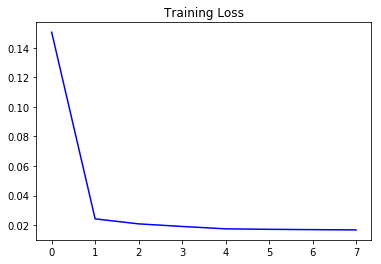

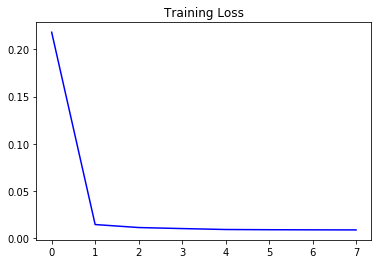

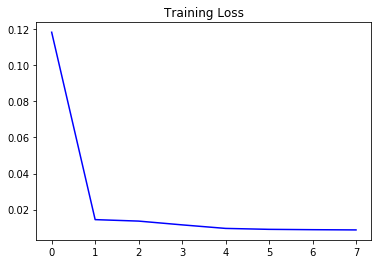

In [9]:
### VISUALIZATION ###
def training_plot(metrics):
    plt.figure(1)
    plt.plot([m.loss for m in metrics], 'b')
    plt.title('Training Loss')
    plt.show()

training_plot(sgd_trainer.metrics)
training_plot(adam_trainer.metrics)
training_plot(rms_trainer.metrics)

## Parameter Initialization

While training a network, the initial value of the weights plays a significant role. In the extreme case, an oracle could just set the weights directly to values that minimize the objective function, and in practical cases a good initialization can bring us to a more favorable starting position in the parameter space. 

This raises the question of how to choose these weights. 

- What happens if all the weights are set to zero? The gradients become zero, and the network finds itself without a direction. 
- What if all of them are set to the same non-zero value? Although the gradients are no longer zero, each neuron has the same weight and follows the same gradient. Such neurons will continue to have the same value, since they're identical - it will not be easy to retrain them to display diversity.


**What are some of the initialization methods then?**


- Random initialization. Let's begin with creating a weight initialization function that samples from **N(0,1)**. A clean way of initializing the weights is to access the network parameters by traversing all modules inside the network, and then applying the desired initialization. This method also allows us to encapsulate all the initializations into a single function. Note that there is another guideline of random initialization from Stanford 231n course is to do `w=np.random.randn(n)*sqrt(2.0/n)` (but what is `n`?)

- Xavier: Xavier initialization is a way of initializing the weights such that the variance of the inputs is the same as the variance of the outputs. At each layer, the fan_in and fan_out (i.e. input connections and output connections) might be different. To calculate the variance, you will multiply each weight with the inputs. Evidently, if the number of inputs is less, they will need to be multiplied with higher weights so that they can sum up to the product of a larger number of outputs with smaller weights. This is the intuition behind Xavier initialization.

- Pretraining: you might also need to have specific methods to initialize the weights in different layers. For example, you might want to use a pretrained model like Alexnet to give your network a head start for visual recognition tasks. 

**What are the other motivations?**

(1) avoid blowing-up/diminishing gradients and hence allow higher learning rates, since extreme gradients are caused by extrem activation maps; (2) reduce (not remove) strong dependency on initialization.

**What are the other things to keep in mind?**
There is no single initializtion method that achieve the best performance empirically. But when you are comparing models with others, make sure you are using the same initialization - since those make a difference.

In [10]:
def init_randn(m):
    if type(m) == nn.Linear:
        m.weight.data.normal_(0,1)

Now let's use this scheme to initialize the network. Note that *apply(fn)* applies the function *fn* recursively to every submodule (as returned by .children()) as well as self. Also, since it is applied to itself as well, you must **take care to select the appropriate type of module *m* and apply the initialization to it**.

In [11]:
normalmodel = FashionModel()
normalmodel.apply(init_randn)

FashionModel(
  (fc1): Linear(in_features=784, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=10, bias=True)
)

We could also customize the way to initialize the weights, where you explicitly copy some values into the weights.

In [12]:
def init_custom(m):
    if type(m) == nn.Linear:
        rw = torch.randn(m.weight.data.size())
        m.weight.data.copy_(rw)

Now let's use this initialization scheme to implement Xavier initialization. 

In [13]:
def init_xavier(m):
    if type(m) == nn.Linear:
        fan_in = m.weight.size()[1]
        fan_out = m.weight.size()[0]
        std = np.sqrt(2.0 / (fan_in + fan_out))
        m.weight.data.normal_(0,std)

In [14]:
xaviermodel = FashionModel()
xaviermodel.apply(init_xavier)

FashionModel(
  (fc1): Linear(in_features=784, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=10, bias=True)
)

In [15]:
### LET'S TRAIN ###
n_epochs = 3

print("NORMAL INIT WEIGHTS")
AdamOptimizer = torch.optim.Adam(normalmodel.parameters(), lr=0.001)
normal_trainer = Trainer(normalmodel, AdamOptimizer)
normal_trainer.run(n_epochs)
normal_trainer.save_model('./normal_model.pt')
print('')


print("XAVIER INIT WEIGHTS")
AdamOptimizer = torch.optim.Adam(xaviermodel.parameters(), lr=0.001)
xavier_trainer = Trainer(xaviermodel, AdamOptimizer)
xavier_trainer.run(n_epochs)
xavier_trainer.save_model('./xavier_model.pt')
print('')

NORMAL INIT WEIGHTS
Start Training...


/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  # This is added back by InteractiveShellApp.init_path()


epoch: 1, loss: 1.03235789
epoch: 2, loss: 0.13374807
epoch: 3, loss: 0.05081917

XAVIER INIT WEIGHTS
Start Training...
epoch: 1, loss: 0.00534270
epoch: 2, loss: 0.00384763
epoch: 3, loss: 0.00347136



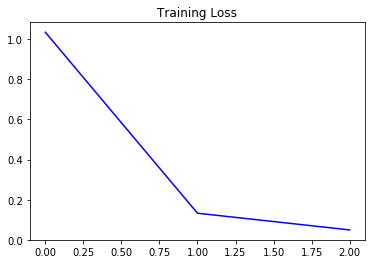

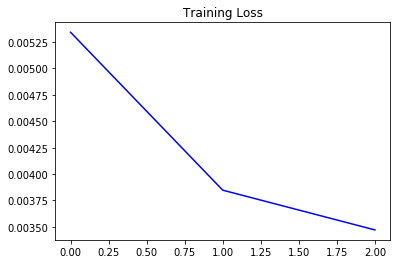

In [16]:
### VISUALIZATION ###
def training_plot(metrics):
    plt.figure(1)
    plt.plot([m.loss for m in metrics], 'b')
    plt.title('Training Loss')
    plt.show()

training_plot(normal_trainer.metrics)
training_plot(xavier_trainer.metrics)

In [1]:
# Using pretrained weights of Alex net.
alexnet_model = models.alexnet(pretrained=True)

NameError: name 'models' is not defined

## Batch Normalization


**What is it?**

Batch normalization is to normalize each mini-batch to be statistically similar to every other batch, by applying an affine combination of the batch of inputs, aggregating the statistics over that mini-batch and normalize the batch by these statistics.


**Why do we do it?**
This is to deal with a phenomenon in machine learning called *covariate shift*, which the covariate distribution is non-stationary (a) over the course of training, a common phenomenon in online learning; (b) or across mini-batches (imagine in the current examples, we have been seeing training examples of red outfit, but then some green ones arrive)

More generally, the distribution of individual node and layer activity shifts as the network parameters are updated. As an abstraction, we can consider each node's activity to be a covariate of the following nodes in the network. Thus we can think of the non-stationarity of node (and layer) activations as a sort of *internal covariate shift*. Why is internal covariate shift a problem? Each subsequent layer has to account for a shifting distribution of its inputs. For saturating non-linearities the problem becomes even more dire, as the shift in activity will more likely place the unit output in the saturated region of the non-linearity.

What is more, BatchNorm introduces some randomness in the final trained network, and generate an effect close to regularization. BatchNorm also avoids the blowing-up/diminishing gradients and hence also allow higher learning rates. 

**What other things to keep in mind?**

It is usually used after the affine transformation and before the activation, because you may lose info after the activation. But if activation produces input to other layers, it is also normal to apply BatchNorm.

In [3]:
class BatchNorm(nn.Module):

    def __init__(self, num_features):
        super(BatchNorm, self).__init__()
        self.num_features = num_features
        self.affine = affine
        self.weight = Parameter(torch.Tensor(num_features))
        self.bias = Parameter(torch.Tensor(num_features))
        self.register_buffer('running_mean', torch.zeros(num_features))
        self.register_buffer('running_var', torch.ones(num_features))
        self.reset_parameters()

    def reset_parameters(self):
        self.running_mean.zero_()
        self.running_var.fill_(1)
        self.weight.data.uniform_()
        self.bias.data.zero_()

    def forward(self, x):
        pass

NameError: name 'nn' is not defined

## Regularization (weight_decay)

Weight decay specifies regularization in the neural network.

During training, a regularization term is added to the network's loss to compute the backpropagation gradient. The weight decay value determines how dominant this regularization term will be in the gradient computation.

The most usual form of regularizations are
    
 > L2, or ridge, which produces diffuse weights
    
 > L1, or Lasso, which produces sparse weights
    
 > **maxnorm**: Another form of regularization is to enforce an absolute upper bound on the magnitude of the weight vector for every neuron and use projected gradient descent to enforce the constraint. In practice, this corresponds to performing the parameter update as normal, and then enforcing the constraint by clamping the weight vector of every neuron. Typically the upper bounds are on orders of 3 or 4. Some people report improvements when using this form of regularization. One of its appealing properties is that network cannot “explode” even when the learning rates are set too high because the updates are always bounded. (Not sure if PyTorch has this regularization though).
   
 > **Dropout** is that for the training phase, for each hidden layer, for each training sample and for each iteration, ignore (zero out) a random selection of neurons as well as its corresponding inputs/outputs. It is a regularization technique for reducing overfitting in neural networks by preventing complex co-adaptations on training data. It is considered a form of regularization since it conforms to the theme of introducing noise at the forward pass. It is a very efficient way of performing model averaging with neural networks - intuition why this works is similar to emsemble: different local minima are reached by different random samples. The term "dropout" refers to dropping out units in a neural network - note that you do not need to that in testing (in PyTorch, for `.eval` the toggle for dropout is turned off). Typical dropout probability is around 0.1 to 0.5. Note that for the original dropouts, inputs need to be scaled at training time; but nowadays, dropout is usually done in an **inverse version**, so that in testing time there is no scaling needed, for faster inference:

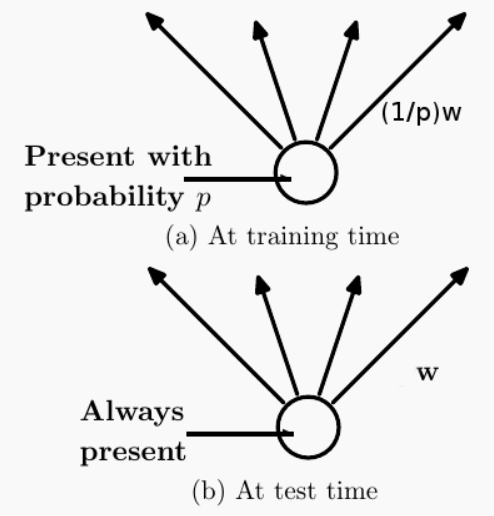


 
   > Note: dropout and BatchNorm cannot be used together, otherwise it leads to worse performance. This has to do with the variance shift between training and testing; see [Understanding the Disharmony between Dropout and Batch Normalization by
Variance Shift](https://arxiv.org/pdf/1801.05134.pdf)
   
 > Early stopping: in the general sense, it fits the theme of introducing noice to the training.

As a rule of thumb, the more training examples you have, the weaker this term should be. The more parameters you have the higher this term should be.

In [ ]:
### Example of a step decay

def step_decay(epoch):
    initial_lrate = 0.1
    drop = 0.5
    epochs_drop = 10.0
    lrate = initial_lrate * math.pow(drop,  
           math.floor((1+epoch)/epochs_drop))
    return lrate

In [2]:
### MODELS WITH BATCHNORM AND DROPOUT ###
class FashionModel_Tricks(nn.Module):
    
    def __init__(self):
        super(FashionModel_Tricks, self).__init__()
        self.fc1 = nn.Linear(784, 64)
        self.bnorm1 = nn.BatchNorm1d(64)
        self.dp1 = nn.Dropout(p=0.2)
        self.fc2 = nn.Linear(64, 32)
        self.bnorm2 = nn.BatchNorm1d(32)
        self.dp2 = nn.Dropout(p=0.1)
        self.fc3 = nn.Linear(32, 10)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dp1(self.bnorm1(x))
        x = F.relu(self.fc2(x))
        x = self.dp2(self.bnorm2(x))
        x = F.log_softmax(self.fc3(x))
        return x
print(FashionModel_Tricks())

NameError: name 'nn' is not defined

In [ ]:
### TRAIN MODELS WITH BATCHNORM AND DROPOUT ###
n_epochs = 10

model = FashionModel_Tricks()
optimizer = torch.optim.SGD(model.parameters(), lr = 0.001, momentum = 0.9, weight_decay = 0.001)
btrainer = Trainer(model, optimizer)
btrainer.run(n_epochs)
btrainer.save_model('./dropout-batchnorm_optimized_model.pt')

training_plot(btrainer.metrics)

print('')

Start Training...


/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/ipykernel_launcher.py:18: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


epoch: 1, loss: 0.01287768
epoch: 2, loss: 0.00694797
epoch: 3, loss: 0.00550364
epoch: 4, loss: 0.00490236


## Gradient Clipping

During experimentation, once the gradient value grows extremely large, it causes an overflow (i.e. NaN) which is easily detectable at runtime or in a less extreme situation, the Model starts overshooting past our Minima; this issue is called the Gradient Explosion Problem.

Gradient clipping will ‘clip’ the gradients or cap them to a Threshold value to prevent the gradients from getting too large.

In [ ]:
#Gradient Clipping 
# `clip_grad_norm` helps prevent the exploding gradient problem. To be used before optimizer.step()during training
torch.nn.utils.clip_grad_norm(model.parameters(), 0.25)

## Data Preprocessing to the Input Data

- One may to preprocess is to center the data to have a mean of $0$, and normalize its scale to $[-1, 1]$ along each feature. This may help the ill-conditional covariance matrix of the features. One thing to note is that in this approach, the preprocessing statistics, such as the mean, should only be computed on the training data, and then applied to validation and testing - we cannot just normalize the validation and testing data themselves.

- Shuffle the dataset, or it is possible that during training your neural net will pick up on that as a shortcut yet undesired way of learning. In Pytorch, `DataLoader` has an option to enable shuffling; see the very beginning.

## Hyperparameter Optimization

- Parallel the search and do early stopping.
- Prefer one validation fold to cross validation
- Search for hyperparameters on log scale
- Prefer random search to grid search
- Careful with best value that are on the border - look beyond the border!
- Stage your search from coarse to fine.

## Model Ensembles

- Same models. Different Initializations
- Top-model discovered during cross-validation
- Different checkpoints of a single model
- Running average of parameters during training

## References

- CMU Deep Learning Course Fall 2019.
- Stanford 231n

### Further Reading

- Rprop and QuickProp in CMU course Fall 2019, Lecture 5.